In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download akashsuper2000/toxic-comment-classification

! unzip toxic-comment-classification.zip -d /input

! ls /input

 83% 17.0M/20.5M [00:00<00:00, 14.0MB/s]
100% 20.5M/20.5M [00:00<00:00, 30.0MB/s]
Archive:  toxic-comment-classification.zip
  inflating: /input/test.csv         
  inflating: /input/train.csv        
  inflating: /input/validation.csv   
test.csv  train.csv  validation.csv


In [212]:
# import warnings
# warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import string

import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [213]:
trainData = pd.read_csv('/input/train.csv')

testData = pd.read_csv('/input/test.csv')

trainData.head()

,comment_text,toxic
0,"Wasn't me, asshole. Check your fucking IP's b...",1
1,Stupid law. Why does Quebec always have to ca...,1
2,after qualifying for the Wimbledon main draw -...,1
3,THE QUESTION IS NOT WHETHER IT'S ART OR PORNOG...,1
4,fuck you white trash!!!,1


# Data Cleaning

In [214]:
stpWords=stopwords.words('english')

def RemoveLinks(text):
  return re.sub('^(http|https)://\S+|www\.\S+','',text)

def RemovePunctuation(text):
  text = re.sub('<.*?>+','',text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  return re.sub('\n','',text)

def RemoveNumbers(text):
  return re.sub('\w*\d\w*','',text)

def RemoveStopWords(text):
  return ' '.join([word for word in text.split() if word not in stpWords])

In [215]:
trainData['cleanedText'] = trainData['comment_text'].str.lower()
trainData['cleanedText'] = trainData['cleanedText'].apply(RemoveLinks)
trainData['cleanedText'] = trainData['cleanedText'].apply(RemovePunctuation)
trainData['cleanedText'] = trainData['cleanedText'].apply(RemoveNumbers)
trainData['cleanedText'] = trainData['cleanedText'].apply(RemoveStopWords)

trainData.head()

,comment_text,toxic,cleanedText
0,"Wasn't me, asshole. Check your fucking IP's b...",1,wasnt asshole check fucking ips go shooting mouth
1,Stupid law. Why does Quebec always have to ca...,1,stupid law quebec always cause fuss everything...
2,after qualifying for the Wimbledon main draw -...,1,qualifying wimbledon main draw didnt given wil...
3,THE QUESTION IS NOT WHETHER IT'S ART OR PORNOG...,1,question whether art pornography people questi...
4,fuck you white trash!!!,1,fuck white trash


In [216]:
testData['cleanedText'] = testData['comment_text'].str.lower()
testData['cleanedText'] = testData['cleanedText'].apply(RemoveLinks)
testData['cleanedText'] = testData['cleanedText'].apply(RemovePunctuation)
testData['cleanedText'] = testData['cleanedText'].apply(RemoveNumbers)
testData['cleanedText'] = testData['cleanedText'].apply(RemoveStopWords)

testData.head()

,comment_text,toxic,cleanedText
0,This letter perfectly illustrates why any hope...,1,letter perfectly illustrates hoped reconciliat...
1,One muslim casualty vs the hundreds and thousa...,1,one muslim casualty vs hundreds thousands vict...
2,(fuck you Osama bin laden and your afghanistan...,1,fuck osama bin laden afghanistani terrorist cunts
3,As long as Trump keeps Stiggin' It to the libs...,1,long trump keeps stiggin libs palinamericans w...
4,This article is a load of crap.... Another Fa...,1,article load crap another fake news poll


# Count Of Words & Tokenize

In [219]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [220]:
trainData['tokens'] = trainData['cleanedText'].apply(lambda text:word_tokenize(text))
trainData.head()

,comment_text,toxic,cleanedText,tokens
0,"Wasn't me, asshole. Check your fucking IP's b...",1,wasnt asshole check fucking ips go shooting mouth,"[wasnt, asshole, check, fucking, ips, go, shoo..."
1,Stupid law. Why does Quebec always have to ca...,1,stupid law quebec always cause fuss everything...,"[stupid, law, quebec, always, cause, fuss, eve..."
2,after qualifying for the Wimbledon main draw -...,1,qualifying wimbledon main draw didnt given wil...,"[qualifying, wimbledon, main, draw, didnt, giv..."
3,THE QUESTION IS NOT WHETHER IT'S ART OR PORNOG...,1,question whether art pornography people questi...,"[question, whether, art, pornography, people, ..."
4,fuck you white trash!!!,1,fuck white trash,"[fuck, white, trash]"


In [221]:
testData['tokens'] = testData['cleanedText'].apply(lambda text:word_tokenize(text))
testData.head()

,comment_text,toxic,cleanedText,tokens
0,This letter perfectly illustrates why any hope...,1,letter perfectly illustrates hoped reconciliat...,"[letter, perfectly, illustrates, hoped, reconc..."
1,One muslim casualty vs the hundreds and thousa...,1,one muslim casualty vs hundreds thousands vict...,"[one, muslim, casualty, vs, hundreds, thousand..."
2,(fuck you Osama bin laden and your afghanistan...,1,fuck osama bin laden afghanistani terrorist cunts,"[fuck, osama, bin, laden, afghanistani, terror..."
3,As long as Trump keeps Stiggin' It to the libs...,1,long trump keeps stiggin libs palinamericans w...,"[long, trump, keeps, stiggin, libs, palinameri..."
4,This article is a load of crap.... Another Fa...,1,article load crap another fake news poll,"[article, load, crap, another, fake, news, poll]"


In [222]:
freq = FreqDist()
for sample in range(len(trainData)):
  freq.update(trainData.iloc[sample]['tokens'])

In [223]:
pd.DataFrame(np.array(freq.most_common(10)))

,0,1
0,article,23536
1,like,20443
2,page,18621
3,would,17497
4,dont,17079
5,one,16722
6,people,15622
7,wikipedia,14769
8,think,12225
9,talk,12073


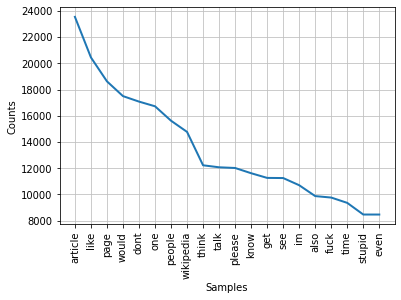

In [224]:
freq.plot(20)

# Count Of 2-grams

In [225]:
from nltk import ngrams

del freq

tmpNgram=[]
for sample in range(len(trainData)):
  try:
    tmpNgram.extend(list(ngrams(trainData.iloc[sample]['tokens'],2)))
  except:
    pass

In [226]:
freq = FreqDist(tmpNgram)
freq.most_common(10)

[(('talk', 'page'), 5332),
 (('nigger', 'nigger'), 3658),
 (('fuck', 'fuck'), 3272),
 (('can', 'not'), 1905),
 (('dont', 'know'), 1819),
 (('speedy', 'deletion'), 1614),
 (('would', 'like'), 1564),
 (('’', 's'), 1534),
 (('poop', 'poop'), 1353),
 (('hate', 'youi'), 1254)]

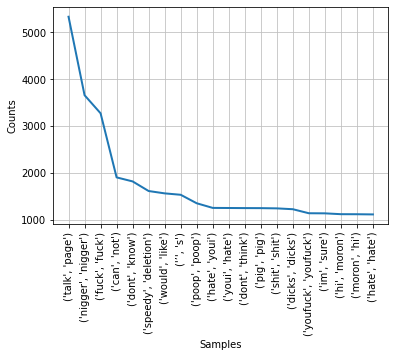

In [227]:
freq.plot(20)

# A Little More of EDA

In [229]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  120000 non-null  object
 1   toxic         120000 non-null  int64 
 2   cleanedText   120000 non-null  object
 3   tokens        120000 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.7+ MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


<BarContainer object of 2 artists>

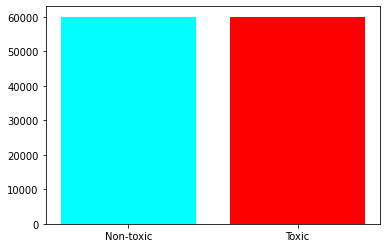

In [230]:
distributionOfClasses = trainData.groupby('toxic').count()

distributionOfClasses.toxic=['Non-toxic','Toxic']
plt.bar(distributionOfClasses.toxic, distributionOfClasses.comment_text, color=['cyan','red'])

In [231]:
distributionOfLength=pd.DataFrame()
distributionOfLength['comment_text'] = trainData['comment_text'].apply(len)
distributionOfLength['toxic'] = trainData.toxic
distributionOfLength.head()

,comment_text,toxic
0,83,1
1,118,1
2,107,1
3,112,1
4,23,1


{'bodies': [<matplotlib.collections.PolyCollection at 0x7ff3cddefc50>,
 'cbars': <matplotlib.collections.LineCollection at 0x7ff3cddef490>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7ff3cddef9d0>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7ff3cdde8410>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7ff3cddef750>,
 'cmins': <matplotlib.collections.LineCollection at 0x7ff3cddefcd0>}

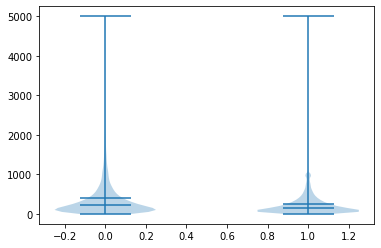

In [232]:
plt.violinplot(
    [distributionOfLength[distributionOfLength.toxic==0].comment_text.values ,distributionOfLength[distributionOfLength.toxic==1].comment_text.values]
    , [0,1],
    showmeans=True, showextrema=True, showmedians=True)


## Word cloud - Most Frequent Words

### Negative class

In [233]:
from wordcloud import WordCloud

import random
def NegativeColorWordCloud(word, font_size, position, orientation, random_state=None, **kwargs):
    return f'hsl({random.randint(0, 42)}, {random.randint(80, 100)}%, 50%)'

def PositiveColorWordCloud(word, font_size, position, orientation, random_state=None, **kwargs):
    return f'hsl({random.randint(97, 161)}, {random.randint(80, 100)}%, 50%)'

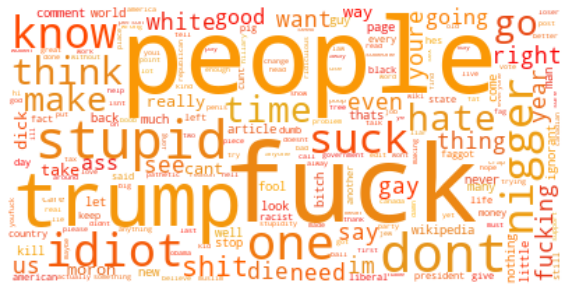

In [234]:
wordCloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(trainData[trainData['toxic']==1].cleanedText))

wordCloud.recolor(color_func=NegativeColorWordCloud)

plt.figure(figsize=(10,12))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Positive class

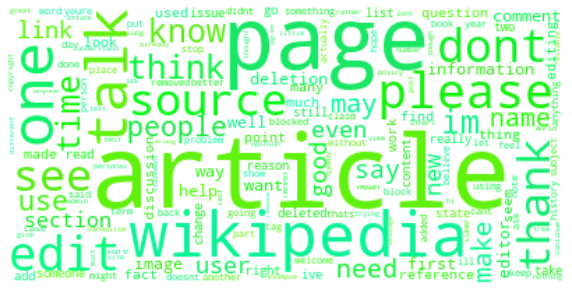

In [235]:
wordCloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(trainData[trainData['toxic']==0].cleanedText))

wordCloud.recolor(color_func=PositiveColorWordCloud)

plt.figure(figsize=(10,12))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Glove

## Download GLoVe

In [25]:
! wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip

--2021-11-20 17:00:06--  http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/wordvecs/glove.6B.zip [following]
--2021-11-20 17:00:06--  https://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip [following]
--2021-11-20 17:00:07--  http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182753 (822M) [applic

In [26]:
! unzip glove.6B.zip -d /input
! ls /input

Archive:  glove.6B.zip
  inflating: /input/glove.6B.100d.txt  
  inflating: /input/glove.6B.200d.txt  
  inflating: /input/glove.6B.300d.txt  
  inflating: /input/glove.6B.50d.txt  
glove.6B.100d.txt  glove.6B.300d.txt  test.csv	 validation.csv
glove.6B.200d.txt  glove.6B.50d.txt   train.csv


In [27]:
! head -n 1 /input/glove.6B.100d.txt

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062


Each row represents:
* Word.
* Feature vector of that word.

## Loading GLoVe

In [ ]:
FEATURES=100

glove = pd.read_csv(f'/input/glove.6B.{FEATURES}d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove = {key: val.values for key, val in glove.T.items()}
glove

In [29]:
glove['car']

array([-0.1684  , -0.53827 ,  0.31155 , -0.53218 ,  0.26678 , -0.13638 ,
        0.36621 ,  0.68383 ,  0.77726 ,  0.68049 ,  0.69137 ,  0.2103  ,
        0.091065,  0.24845 , -0.16157 ,  0.46291 , -0.1503  ,  0.2562  ,
       -0.1199  ,  0.5913  ,  1.0351  , -0.2052  ,  0.30244 , -0.34101 ,
        0.6326  , -0.31603 , -0.9959  , -0.33583 ,  0.25161 ,  0.10323 ,
        0.019611,  0.54893 , -0.33433 ,  0.29617 ,  0.41218 ,  0.4207  ,
        0.25775 ,  0.12709 ,  0.80269 ,  0.61944 ,  0.54316 , -0.5941  ,
        0.87551 , -0.063686, -0.29117 ,  0.61609 ,  0.33376 ,  0.14488 ,
       -0.039021, -1.1849  , -0.45951 ,  0.15631 , -0.50818 ,  1.2357  ,
        0.30965 , -1.958   , -1.1872  ,  1.2027  ,  2.1138  ,  0.083629,
        0.54319 ,  0.78883 ,  0.35416 ,  0.87736 ,  0.54007 , -0.10454 ,
        0.075371, -0.45727 , -0.27466 ,  0.11838 , -0.49412 , -0.61325 ,
        0.071519, -0.57665 ,  0.21371 ,  0.62137 ,  1.4404  , -0.34033 ,
       -0.89958 , -0.69605 ,  0.74058 ,  0.52105 , 

## Example Initialization

In [ ]:
weightsMatrix = np.zeros((len(freq), FEATURES))

for i, word in enumerate(freq):
  try:
    weightsMatrix[i]=glove[word[0]]
  except:
    weightsMatrix[i] = np.random.normal(scale=0.6, size=(FEATURES,))

In [ ]:
weightsMatrix

array([[-0.8991   ,  0.632    ,  0.0015818, ..., -1.0175   ,  0.48082  ,
        -0.17651  ],
       [-0.27086  ,  0.044006 , -0.02026  , ..., -0.4923   ,  0.63687  ,
         0.23642  ],
       [-0.11752  ,  0.97272  , -0.29021  , ..., -0.50598  , -0.28476  ,
        -0.70045  ],
       ...,
       [-0.11752  ,  0.97272  , -0.29021  , ..., -0.50598  , -0.28476  ,
        -0.70045  ],
       [-0.11752  ,  0.97272  , -0.29021  , ..., -0.50598  , -0.28476  ,
        -0.70045  ],
       [-1.014    ,  0.078819 ,  0.47789  , ..., -0.21606  ,  0.81187  ,
        -0.88524  ]])

# Pytorch and Preparing Features

In [ ]:
! ls /input

test.csv  train.csv  validation.csv


In [236]:
from collections import Counter
wordCounter = Counter()
sentences = []

In [237]:
# Define a limit of 100 words in the sentence.
# Example of such definition
from tqdm import tqdm

TOKEN_LIMIT=100

labels=[]

for index in tqdm(range(len(trainData))):
  row = trainData.iloc[index]
  sentence = row.cleanedText
  words = word_tokenize(sentence)[:TOKEN_LIMIT]
  if len(words)==0:
    continue
  wordCounter.update(words)
  
  labels.append(row.toxic)
  sentences.append(words)

100%|██████████| 120000/120000 [01:08<00:00, 1756.10it/s]


In [238]:
sentences[0]

['wasnt', 'asshole', 'check', 'fucking', 'ips', 'go', 'shooting', 'mouth']

In [239]:
labels[0]

1

In [ ]:
wordCounter

In [241]:
trainData['tokens']=trainData['tokens'].apply(lambda tokens: tokens[:TOKEN_LIMIT])
testData['tokens']=testData['tokens'].apply(lambda tokens: tokens[:TOKEN_LIMIT])

In [242]:
trainData.head()

,comment_text,toxic,cleanedText,tokens
0,"Wasn't me, asshole. Check your fucking IP's b...",1,wasnt asshole check fucking ips go shooting mouth,"[wasnt, asshole, check, fucking, ips, go, shoo..."
1,Stupid law. Why does Quebec always have to ca...,1,stupid law quebec always cause fuss everything...,"[stupid, law, quebec, always, cause, fuss, eve..."
2,after qualifying for the Wimbledon main draw -...,1,qualifying wimbledon main draw didnt given wil...,"[qualifying, wimbledon, main, draw, didnt, giv..."
3,THE QUESTION IS NOT WHETHER IT'S ART OR PORNOG...,1,question whether art pornography people questi...,"[question, whether, art, pornography, people, ..."
4,fuck you white trash!!!,1,fuck white trash,"[fuck, white, trash]"


In [243]:
testData.head()

,comment_text,toxic,cleanedText,tokens
0,This letter perfectly illustrates why any hope...,1,letter perfectly illustrates hoped reconciliat...,"[letter, perfectly, illustrates, hoped, reconc..."
1,One muslim casualty vs the hundreds and thousa...,1,one muslim casualty vs hundreds thousands vict...,"[one, muslim, casualty, vs, hundreds, thousand..."
2,(fuck you Osama bin laden and your afghanistan...,1,fuck osama bin laden afghanistani terrorist cunts,"[fuck, osama, bin, laden, afghanistani, terror..."
3,As long as Trump keeps Stiggin' It to the libs...,1,long trump keeps stiggin libs palinamericans w...,"[long, trump, keeps, stiggin, libs, palinameri..."
4,This article is a load of crap.... Another Fa...,1,article load crap another fake news poll,"[article, load, crap, another, fake, news, poll]"


In [244]:
trainData=trainData.drop(trainData[trainData['tokens'].map(len)==0].index)
testData=testData.drop(testData[testData['tokens'].map(len)==0].index)

In [249]:
trainData=trainData.reset_index(drop=True)
testData=testData.reset_index(drop=True)

## Assigning ID to each word in the training

In [ ]:
MIN_COUNT_WORD=0

wordMap=dict()
wordMap['<pad>']=0
for word, count in wordCounter.items():
  if count > MIN_COUNT_WORD:
    wordMap[word]=len(wordMap)
wordMap['<unk>']=len(wordMap)
wordMap

In [252]:
# Save for future use
import json
with open('wordMap.json', 'w') as wm:
  json.dump(wordMap,wm)

## Encode sentences into a LIMIT \# of features

In [253]:
def EncodeSentences(df, wordMap):
  encodedSentences = list(
      map(
          lambda sntc: 
            list(
              map(lambda word: wordMap.get(word, wordMap['<unk>']), sntc)
            )
            + [0] * (TOKEN_LIMIT-len(sntc))
      , df.tokens)
  )

  wordsInSentences = list(map(lambda sntc: len(sntc), df.tokens))

  labels = df.toxic

  return encodedSentences, wordsInSentences, labels

In [254]:
trainEncodedSentences, trainWordsInSentences, trainLabels = EncodeSentences(trainData,wordMap)
# Everything matches
len(trainEncodedSentences)==len(trainData)==len(trainWordsInSentences)==len(trainLabels)

True

In [ ]:
trainEncodedSentences[0]

In [256]:
# Save for future use
torch.save({
    'sentences':trainEncodedSentences,
    'labels':trainLabels,
    'wordsInsentences': trainWordsInSentences
}, 'TRAIN_data.pth.tar')
del trainEncodedSentences, trainLabels, trainWordsInSentences, sentences

In [257]:
testEncodedSentences, testWordsInSentences, testLabels = EncodeSentences(testData,wordMap)
# Everything matches
len(testEncodedSentences)==len(testData)==len(testWordsInSentences)==len(testLabels)

True

In [ ]:
testEncodedSentences[0]

In [259]:
# Save for future use
torch.save({
    'sentences':testEncodedSentences,
    'labels':testLabels,
    'wordsInsentences': testWordsInSentences
}, 'TEST_data.pth.tar')
del testEncodedSentences, testLabels, testWordsInSentences

## Create Pytorch dataset

In [260]:
class ToxicComments(Dataset):
  def __init__(self, dataToLoad='TRAIN_data.pth.tar'):
    data = torch.load(dataToLoad)
    self.sentences = data['sentences']
    self.labels = data['labels']
    self.wordsInSentences = data['wordsInsentences']

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, id):
    return torch.tensor(self.sentences[id], dtype=torch.long), torch.tensor(self.labels[id], dtype=torch.long), torch.tensor(self.wordsInSentences[id], dtype=torch.long)

In [261]:
trainDataset = ToxicComments('TRAIN_data.pth.tar')
trainLoader = DataLoader(trainDataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

testDataset = ToxicComments(dataToLoad='TEST_data.pth.tar')
testLoader = DataLoader(testDataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

In [262]:
for i, data in enumerate(trainLoader):
  print(data[0])
  print(data[1])
  print(data[2])
  break
# It represents sentences as their words IDs. If the remaining length is not 100 or greater, the sentence is filled with 0's

tensor([[45515,   133,  2509,  ...,     0,     0,     0],
        [  175, 13068,  1709,  ...,     0,     0,     0],
        [13782, 84840, 13519,  ...,     0,     0,     0],
        ...,
        [ 3370,  2287,   185,  ...,     0,     0,     0],
        [ 2288,  1243,  1357,  ...,     0,     0,     0],
        [ 5712,  1007,     0,  ...,     0,     0,     0]])
tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0])
tensor([ 24,  12,   6,  17,  10,  34,   2,   9,  30,  19, 100,   7,   7,  12,
         62,   2])


In [263]:
for i, data in enumerate(testLoader):
  print(data[0])
  break
# It represents sentences as their words IDs. If the remaining length is not 100 or greater, the sentence is filled with 0's

tensor([[  147,  1290,  5175,  ...,     0,     0,     0],
        [  100,  1258,  1494,  ...,     0,     0,     0],
        [ 7306,   201,  5091,  ...,     0,     0,     0],
        ...,
        [ 2206,    63, 14071,  ...,     0,     0,     0],
        [ 3827,  6637,  1004,  ...,     0,     0,     0],
        [ 2055,   555,  2910,  ...,     0,     0,     0]])


In [264]:
# Load word2Id vocabulary
with open('wordMap.json', 'r') as wm:
  # Words to IDs
  wordMap = json.load(wm)

vocab = len(wordMap)
labels = ['Non-toxic','Toxic']

labels2Class = {value: id for id, value in enumerate(labels)}
class2Label = {id: value for id, value in enumerate(labels)}

NUM_CLASSES = 2

## Create Embedding Matrix

In [265]:
def InitEmbedding(embeddingMatrix):
  bias = np.sqrt(3.0 / embeddingMatrix.size(1))
  torch.nn.init.uniform_(embeddingMatrix, -bias, bias)
  return embeddingMatrix

In [266]:
FEATURES=100
vocabSet = set(wordMap.keys())
embeddingMatrix = torch.FloatTensor(len(vocabSet), FEATURES)
embeddingMatrix=InitEmbedding(embeddingMatrix)

In [267]:
print(embeddingMatrix.size())
embeddingMatrix

torch.Size([177895, 100])


tensor([[-0.0058,  0.0311,  0.1194,  ...,  0.1331,  0.1650, -0.0146],
        [-0.0662,  0.0116, -0.1583,  ..., -0.0769, -0.0057, -0.0904],
        [ 0.1416, -0.1664,  0.0078,  ...,  0.0925,  0.1641,  0.0201],
        ...,
        [-0.1495,  0.0034, -0.1687,  ..., -0.0851,  0.0270,  0.0419],
        [-0.0327,  0.1723,  0.1406,  ...,  0.1424,  0.1283,  0.0877],
        [ 0.0514, -0.1088, -0.1022,  ...,  0.1591, -0.0167, -0.1045]])

## Load GLoVe Embeddings

In [268]:
def LoadGloveIntoEmbedding(embeddingMatrix, vocab, numFeatures):
  glove = pd.read_csv(f'/input/glove.6B.{numFeatures}d.txt', sep=" ", quoting=3, header=None, index_col=0)
  glove = {key: val.values for key, val in glove.T.items()}
  
  for gloveWord in tqdm(glove.keys()):
    if gloveWord not in vocab:
      continue
    embeddingMatrix[
      wordMap[gloveWord]
    ] = torch.tensor(glove[gloveWord], dtype=torch.float)
  return embeddingMatrix

embeddingMatrix = LoadGloveIntoEmbedding(embeddingMatrix, vocabSet, FEATURES)

100%|██████████| 399999/399999 [00:01<00:00, 295665.69it/s]


In [269]:
embeddingMatrix

tensor([[-0.0058,  0.0311,  0.1194,  ...,  0.1331,  0.1650, -0.0146],
        [ 0.0658,  0.1005, -0.1661,  ..., -0.1200, -0.8541,  1.1391],
        [ 0.1229, -0.3219,  0.3528,  ..., -0.3618, -0.2801,  0.3464],
        ...,
        [-0.1495,  0.0034, -0.1687,  ..., -0.0851,  0.0270,  0.0419],
        [-0.0327,  0.1723,  0.1406,  ...,  0.1424,  0.1283,  0.0877],
        [ 0.2837, -0.6263, -0.4435,  ...,  0.4368, -0.8261, -0.1570]])

In [270]:
# Save for future use
torch.save((embeddingMatrix, FEATURES), 'glove_cache.pth.tar')

## LSTM definition

In [271]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, PackedSequence

class LSTMToxic(nn.Module):
  def __init__(self, embedding, vocabSize, numFeatures,
               rnnSize, numRnnLayers, dropoutRate, numClasses):
    super(LSTMToxic, self).__init__()

    self.rnnSize = rnnSize

    self.embedding = nn.Embedding(vocabSize, numFeatures)
    self.LoadEmbeddings(embedding)

    self.bLSTM = nn.LSTM(
        numFeatures,
        rnnSize,
        num_layers=numRnnLayers,
        bidirectional = True, 
        dropout = (0 if numRnnLayers==1 else dropoutRate),
        batch_first=True
    )
    self.dense = nn.Linear(rnnSize*2, numClasses)

  def LoadEmbeddings(self, embedding):
    self.embedding.weight = nn.Parameter(embedding, requires_grad=False)

  def forward(self, text, wordsInSentence):
    embeddings = self.embedding(text)

    packedWords = pack_padded_sequence(
        embeddings,
        lengths = wordsInSentence.tolist(),
        batch_first = True,
        enforce_sorted = False
    )

    rnnOut, (hidden, cell) = self.bLSTM(packedWords)

    rnnOut = torch.cat(
        (hidden[-2, :, :], hidden[-1, :, :]), dim=1
    )

    return self.dense(rnnOut)



In [272]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE
EPOCHS = 4

model = LSTMToxic(embeddingMatrix, vocab, FEATURES, 70, 1, 0.3, 2).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
lossFn = nn.CrossEntropyLoss().to(DEVICE)

In [279]:
def Train(model, batch, lossFn, optimizer):
  model.train()

  sentences, labels, wordsInSentences = data

  sentences = sentences.to(DEVICE)
  wordsInSentences = wordsInSentences.to(DEVICE)
  labels = labels.to(DEVICE)

  logits = model(sentences, wordsInSentences)

  predictions = nn.Softmax(dim=1)(logits)

  loss = lossFn(predictions, labels)

  correctPredictions = (torch.argmax(predictions, dim=1)==labels).sum()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss.item(), correctPredictions



def Test(model, batch):
  model.eval()
  with torch.no_grad():

    sentences, labels, wordsInSentences = batch
    
    sentences = sentences.to(DEVICE)
    wordsInSentences = wordsInSentences.to(DEVICE)
    labels = labels.to(DEVICE)

    logits = model(sentences, wordsInSentences)

    predictions = nn.Softmax(dim=1)(logits)

    predClasses = torch.argmax(predictions, dim=1)
    correctPredictions = (predClasses==labels).sum()

    return correctPredictions, predClasses, labels
  return

## Training

In [274]:
lossesTraining, lossesTesting = [], []
correctsTraining, correctsTesting = [], []

for epoch in range(EPOCHS):

  print(f'EPOCH {epoch}')

  epochLosses =0
  epochCorrect=0

  with tqdm(trainLoader, unit="batch") as tepoch:
    for data in tepoch:
      loss, correctInBatch = Train(model, data, lossFn, optimizer)

      epochCorrect+=correctInBatch
      epochLosses+=loss
  
  print(f'Epoch {epoch}\'s loss {epochLosses/len(trainLoader)}')
  print(f'Epoch {epoch}\'s accuracy {epochCorrect / len(trainDataset)}')
  lossesTraining.append(
      epochLosses/len(trainLoader)
  )
  correctsTraining.append(
      epochCorrect / len(trainDataset)
  )

print(lossesTraining)
print(correctsTraining)

EPOCH 0


100%|██████████| 7497/7497 [03:24<00:00, 36.68batch/s]


Epoch 0's loss 0.409887677131374
Epoch 0's accuracy 0.8995298147201538
EPOCH 1


100%|██████████| 7497/7497 [03:22<00:00, 37.00batch/s]


Epoch 1's loss 0.3896137090886579
Epoch 1's accuracy 0.9209727644920349
EPOCH 2


100%|██████████| 7497/7497 [03:23<00:00, 36.83batch/s]


Epoch 2's loss 0.38080569364729766
Epoch 2's accuracy 0.9304437041282654
EPOCH 3


100%|██████████| 7497/7497 [03:24<00:00, 36.69batch/s]

Epoch 3's loss 0.37410538684642836
Epoch 3's accuracy 0.9377886652946472
[0.409887677131374, 0.3896137090886579, 0.38080569364729766, 0.37410538684642836]
[tensor(0.8995, device='cuda:0'), tensor(0.9210, device='cuda:0'), tensor(0.9304, device='cuda:0'), tensor(0.9378, device='cuda:0')]


## Distribution of loss

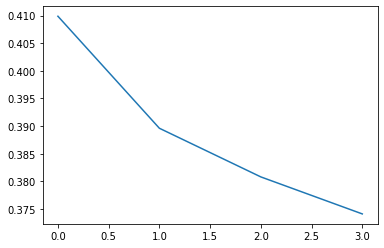

In [308]:
plt.plot(np.arange(0,len(lossesTraining)),lossesTraining)

## Distribution of correct predictions

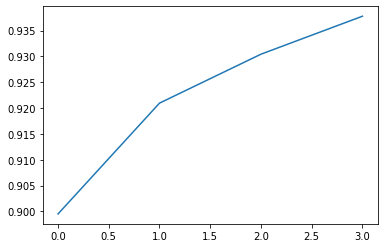

In [309]:
plt.plot(np.arange(0,len(correctsTraining)),correctsTraining)

## Testing after training & results

In [299]:
predictions = torch.empty((1,), dtype=torch.uint8 ,device=DEVICE)
ground = torch.empty((1,), dtype=torch.uint8 ,device=DEVICE)
with tqdm(testLoader, unit="batch") as tepoch:
    for data in tepoch:
      correctPredictions, predClasses, groundClasses = Test(model, data)
      predictions = torch.cat((predictions, predClasses))
      ground = torch.cat((ground, groundClasses))

100%|██████████| 1250/1250 [00:11<00:00, 105.64batch/s]


In [302]:
from sklearn.metrics import confusion_matrix, classification_report

### Confusion matrix

In [303]:
confusion_matrix(ground.cpu().numpy(), predictions.cpu().numpy())

array([[9184,  812],
       [ 690, 9309]])

### Classification report

In [305]:
print(classification_report(ground.cpu().numpy(), predictions.cpu().numpy()))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      9996
           1       0.92      0.93      0.93      9999

    accuracy                           0.92     19995
   macro avg       0.92      0.92      0.92     19995
weighted avg       0.92      0.92      0.92     19995

